In [6]:
import pandas as pd

import numpy as np

In [7]:
data = pd.read_csv('IMDB Dataset.csv')
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [8]:
data.loc[20616,'review']

'Four Friends is one of those films that you go to without any expectations, only to find yourself knocked for a loop. You sort of file it away, but then you hear the song "Georgia On My Mind" by Ray Charles, and images and vague feelings begin to flicker on the edge of your consciousness, and then you remember this crazy film which made you laugh and cry, almost at the same time.<br /><br />Why is this film so memorable? First, at least for people who lived through it all, because it captures so well the tenor of the times - its dashed hopes, its successes, its sincerity and above all the emotional roller-coaster ride that leads to a poignant nostalgia. And then, the acting is just so amazing. Danilow, all angst and passion, Georgia, as difficult to grasp as a will \'o the wisp... but enchanting, nevertheless, and Louis, the handicapped room-mate with charm to spare who attacks life with gusto and takes each moment with a wry smile, because he knows only too well that it just might be

In [9]:
x = data['review']
y = data['sentiment']


In [11]:
import re

In [10]:
from bs4 import BeautifulSoup
def clean_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text(strip=True)

In [11]:
x = x.apply(clean_html)


In [12]:
x = x.str.lower()
x.head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production.the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object

In [13]:
x = x.str.replace(r'[^\w\s]', '', regex=True)
x = x.str.replace(r'\s+', ' ', regex=True)
x.sample(15)

46070    alright this movie might have been good if the...
37953    i had watched as much of the series as i could...
13987    omg this is one of the worst films iv ever see...
15683    part of what was so great about the classic lo...
47599    i really hate most end of the world movies the...
4719     i wasnt able to last ten minutes on the this t...
48694    tarentino should be ashamed to be involved wit...
33630    the last tarzan film starring johnny weissmull...
39029    okay first off seagals voice is dubbed over fo...
40148    there are moments in the film that are so drea...
47838    once again i fell for it in my roots i crave a...
27294    career criminal and crime boss abel davos lino...
32744    there arent too many times when i see a film a...
25816    a study of one of those universally familiar p...
32399    was this supposed to be funny this is one of t...
Name: review, dtype: object

<Axes: ylabel='count'>

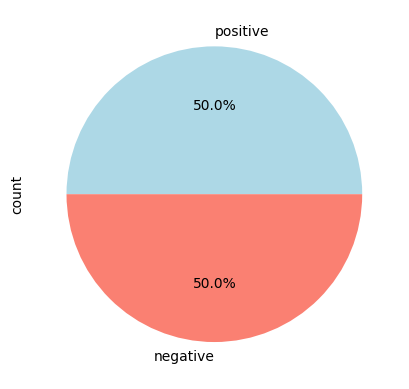

In [14]:
y.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'salmon'])

In [15]:
y = y.map({'positive': 1, 'negative': 0})   

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = list(set(ENGLISH_STOP_WORDS) - {"not",
"no",
"nor",
"never",
"none",
"nothing",
"nowhere",
"neither",
"hardly",
"barely",
"scarcely"})

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    max_features=20000,
    stop_words=custom_stop_words,
    ngram_range=(1, 2)
)

In [21]:
X_train_count = vectorizer.fit_transform(x_train)
X_test_count = vectorizer.transform(x_test)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
                             max_features=5000,
                             stop_words=custom_stop_words,
                             ngram_range=(1, 2),
                             min_df=2)

In [23]:
X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)

In [24]:
!pip install gensim

In [25]:
from gensim.models import Word2Vec
import numpy as np

tokenized_train = [text.split() for text in x_train]

w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

def get_avg_embedding(text):
    words = text.split()
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_w2v = np.array([get_avg_embedding(text) for text in x_train])
X_test_w2v = np.array([get_avg_embedding(text) for text in x_test])

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [26]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

[[4317  644]
 [ 488 4551]]


In [28]:
model.fit(X_train_w2v, y_train)
y_pred = model.predict(X_test_w2v)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4961
           1       0.84      0.85      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

[[4125  836]
 [ 737 4302]]


In [29]:
model.fit(X_train_count, y_train)
y_pred = model.predict(X_test_count)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4961
           1       0.88      0.89      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [30]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

[[4282  679]
 [ 826 4213]]


In [31]:
model.fit(X_train_w2v, y_train)
y_pred = model.predict(X_test_w2v)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      4961
           1       0.80      0.81      0.81      5039

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [32]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [21:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4961
           1       0.85      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [33]:
model.fit(X_train_w2v, y_train)
y_pred = model.predict(X_test_w2v)
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [21:07:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4961
           1       0.83      0.84      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [34]:
!pip install tensorflow==2.15.0
!pip install transformers==4.38.2

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.config.experimental.set_memory_growth(
    tf.config.list_physical_devices('GPU')[0], 
    True
)

In [3]:
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

/Users/prachyasumandas/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2026-02-25 21:22:17.043650: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-02-25 21:22:17.043676: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-25 21:22:17.043680: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-25 21:22:17.043720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
train_encoding = tokenizer(
    x_train.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)
test_encoding = tokenizer(
    x_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encoding),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encoding),
    y_test
))

In [19]:
batch_size = 16

train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2
)

Epoch 1/2
1954/2500 [======================>.......] - ETA: 11:20 - loss: 0.2441 - accuracy: 0.8999

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_dataset).logits
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_test, y_pred))